<a href="https://colab.research.google.com/github/hackviggy/NMBPHD/blob/master/01april1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [0]:
df = pd.read_csv('train-data.csv')

In [0]:
df = df.head(559)

In [6]:
df.shape

(559, 32)

In [7]:
df.head(5)

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,842934,19.772,11.336,134.599,1096.771,0.067,0.326,0.385,0.221,0.217,0.099,1.243,0.979,9.368,168.133,0.024,0.077,0.017,-0.020,-0.004,0.035,27.839,19.029,202.212,2211.972,0.212,0.737,0.781,0.287,0.466,0.133,M
1,843149,22.601,19.453,145.467,1452.768,0.099,0.052,0.042,0.151,0.191,0.140,0.692,0.809,3.642,81.215,0.069,-0.004,0.038,-0.043,0.133,-0.027,27.368,25.600,173.949,2143.103,0.137,0.282,0.311,0.184,0.302,0.196,M
2,84301535,21.507,23.214,142.380,1317.998,0.111,0.266,0.241,0.197,0.166,0.081,0.779,0.852,4.982,103.117,-0.054,0.009,0.071,-0.038,-0.023,0.064,25.882,28.073,167.074,1872.370,0.119,0.395,0.459,0.300,0.361,0.126,M
3,84348933,12.505,22.374,85.098,423.055,0.275,0.252,0.280,0.107,0.250,0.120,0.524,1.282,3.784,29.843,-0.007,0.111,0.062,0.082,0.014,0.001,16.386,28.946,108.286,622.059,0.168,0.971,0.728,0.266,0.737,0.349,M
4,84359034,22.227,15.690,148.024,1420.916,-0.032,0.261,0.230,0.120,0.120,0.087,0.793,0.824,5.970,103.499,0.033,0.087,0.074,0.116,0.052,-0.079,24.687,18.287,166.754,1725.556,0.161,0.234,0.464,0.336,0.218,0.107,M


In [0]:
df.diagnosis = df.diagnosis.map({'M': 1, 'B': 0})

In [9]:
df.head(5)

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,842934,19.772,11.336,134.599,1096.771,0.067,0.326,0.385,0.221,0.217,0.099,1.243,0.979,9.368,168.133,0.024,0.077,0.017,-0.020,-0.004,0.035,27.839,19.029,202.212,2211.972,0.212,0.737,0.781,0.287,0.466,0.133,1
1,843149,22.601,19.453,145.467,1452.768,0.099,0.052,0.042,0.151,0.191,0.140,0.692,0.809,3.642,81.215,0.069,-0.004,0.038,-0.043,0.133,-0.027,27.368,25.600,173.949,2143.103,0.137,0.282,0.311,0.184,0.302,0.196,1
2,84301535,21.507,23.214,142.380,1317.998,0.111,0.266,0.241,0.197,0.166,0.081,0.779,0.852,4.982,103.117,-0.054,0.009,0.071,-0.038,-0.023,0.064,25.882,28.073,167.074,1872.370,0.119,0.395,0.459,0.300,0.361,0.126,1
3,84348933,12.505,22.374,85.098,423.055,0.275,0.252,0.280,0.107,0.250,0.120,0.524,1.282,3.784,29.843,-0.007,0.111,0.062,0.082,0.014,0.001,16.386,28.946,108.286,622.059,0.168,0.971,0.728,0.266,0.737,0.349,1
4,84359034,22.227,15.690,148.024,1420.916,-0.032,0.261,0.230,0.120,0.120,0.087,0.793,0.824,5.970,103.499,0.033,0.087,0.074,0.116,0.052,-0.079,24.687,18.287,166.754,1725.556,0.161,0.234,0.464,0.336,0.218,0.107,1


In [10]:
df.columns

Index(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'diagnosis'],
      dtype='object')

In [0]:
df.drop('id', axis=1, inplace=True)

In [12]:
columns_with_na = df.columns[df.isna().any()].tolist()
columns_with_na

['smoothness_mean',
 'compactness_mean',
 'fractal_dimension_mean',
 'area_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'perimeter_worst',
 'area_worst',
 'compactness_worst']

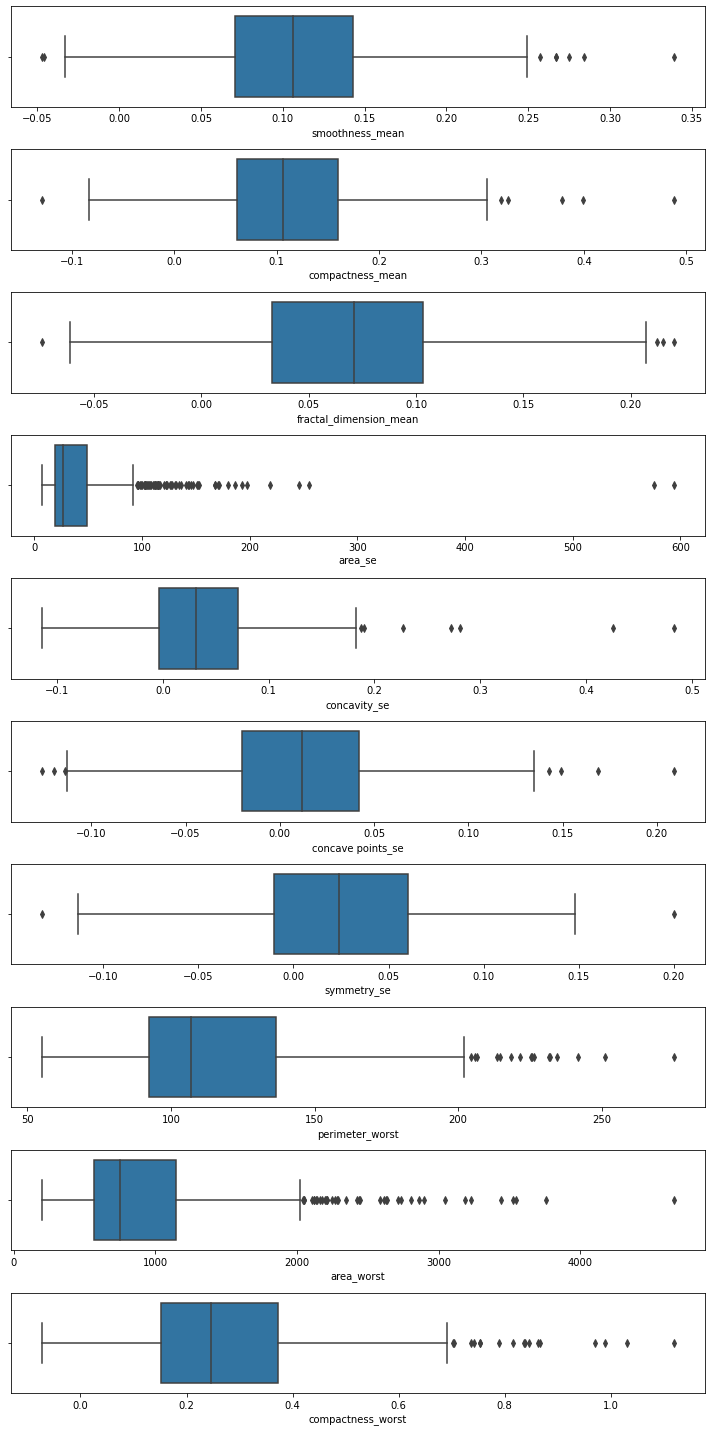

In [13]:
fig = plt.figure(figsize=(10,20))

for i, col_name in enumerate(columns_with_na):
    i += 1
    ax = fig.add_subplot(10, 1, i)
    sns.boxplot(df[col_name])

sns.set_style("whitegrid")
fig.tight_layout()
plt.show()

In [0]:
for col_name in columns_with_na:
    df[col_name].fillna(df[col_name].median(), inplace=True)

In [16]:
df.groupby('diagnosis').mean()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,13.322606,19.521363,85.626139,507.905912,0.103484,0.087133,0.048484,0.026674,0.189569,0.071380,0.308207,1.319949,2.191881,23.147847,0.005275,0.021198,0.030908,0.011093,0.023867,0.004238,14.672346,25.629887,95.537218,613.676596,0.134637,0.202380,0.180654,0.085643,0.300232,0.086683
1,19.077762,23.486544,125.996398,1066.287641,0.117374,0.159578,0.172626,0.095092,0.206097,0.067466,0.660359,1.320835,4.693791,79.106053,0.009767,0.033607,0.044568,0.013592,0.025282,0.004617,23.109602,31.940578,154.387631,1553.453374,0.158762,0.404046,0.488165,0.196728,0.349796,0.097951


ERROR! Session/line number was not unique in database. History logging moved to new session 59


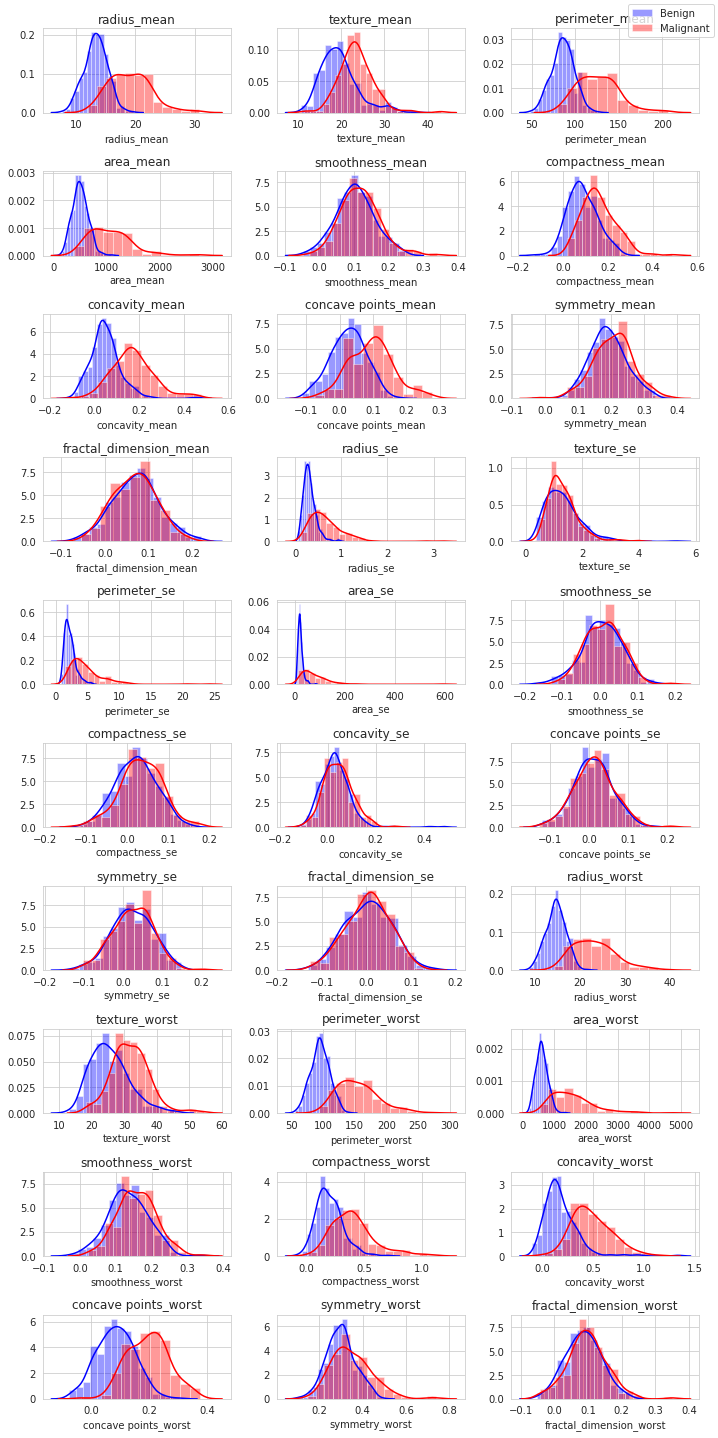

In [17]:
df_benign = df[df['diagnosis'] == 0]
df_malignant = df[df['diagnosis'] == 1]

fig = plt.figure(figsize=(10,20))
for i,col_name in enumerate(list(df.columns[0:30])):
    i +=1
    ax = fig.add_subplot(10,3,i)
    sns.distplot(df_benign[col_name], label = 'Benign', kde = True, color= 'b')
    sns.distplot(df_malignant[col_name], label= 'Malignant', kde = True, color= 'r')
    ax.set_title(col_name)

sns.set_style("whitegrid")
plt.tight_layout()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [0]:
X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,:-1], df['diagnosis'], train_size=0.8, test_size=0.2,
                                                  random_state=0)

In [45]:
df['diagnosis'].value_counts(normalize=True) * 100

0    63.148479
1    36.851521
Name: diagnosis, dtype: float64

In [46]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent',random_state=0)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.7053571428571429

In [0]:
from sklearn.preprocessing import Normalizer

norm = Normalizer()
norm.fit(X_train)
X_train_norm = norm.transform(X_train)
X_val_norm = norm.transform(X_val)

In [50]:
SVM_params = {'C':[0.001, 0.1, 10, 100], 'kernel':['rbf' ,'linear', 'poly', 'sigmoid'], 'gamma':['auto']}
LR_params = {'C':[0.001, 0.1, 1, 10, 100], 'solver':['liblinear']}
LDA_params = {'n_components':[None, 1,2,3], 'solver':['svd'], 'shrinkage':[None]}
RF_params = {'n_estimators':[10,50,100], 'random_state':[0]}
GBC_params = {'n_estimators':[10, 50, 100], 'random_state':[0]}

models_opt = []

models_opt.append(('LR', LogisticRegression(), LR_params))
models_opt.append(('LDA', LinearDiscriminantAnalysis(), LDA_params))
models_opt.append(('RFC', RandomForestClassifier(), RF_params))
models_opt.append(('SVM', SVC(), SVM_params))
models_opt.append(('GBC', GradientBoostingClassifier(), GBC_params))

results = []
names = []

for name, model, params in models_opt:
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    model_grid = GridSearchCV(model, params, cv=5, iid=True)
    cv_results = cross_val_score(model_grid, X_train_norm, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "Cross Validation Accuracy {} Accarcy: {} SD: {}".format(name, cv_results.mean(), cv_results.std())
    print(msg)

Cross Validation Accuracy LR Accarcy: 0.9148813982521847 SD: 0.021144363107057643


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(30, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(30, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(30, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = m

Cross Validation Accuracy LDA Accarcy: 0.937378277153558 SD: 0.015009046250177915
Cross Validation Accuracy RFC Accarcy: 0.9417478152309613 SD: 0.028851173699360976
Cross Validation Accuracy SVM Accarcy: 0.9149063670411985 SD: 0.01852250000450158
Cross Validation Accuracy GBC Accarcy: 0.944019975031211 SD: 0.01753683745143951


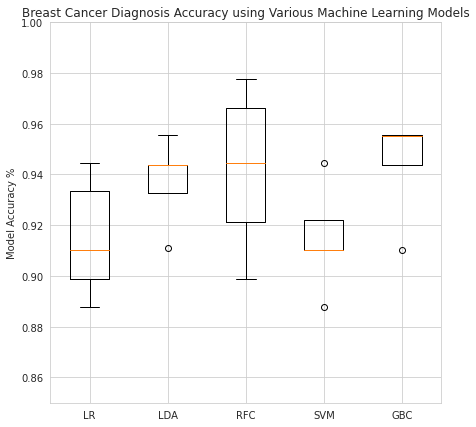

In [51]:
fig = plt.figure(figsize=(7,7))
plt.boxplot(results, labels = names)
plt.title('Breast Cancer Diagnosis Accuracy using Various Machine Learning Models')
plt.ylabel('Model Accuracy %')
sns.set_style("whitegrid")
plt.ylim(0.85,1)
plt.show()

In [52]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_norm, y_train)
lda_predicted = lda.predict(X_val_norm)

print('LDA Accuracy is: {}'.format(accuracy_score(y_val,lda_predicted)))

print('LDA Classification Report')
print(classification_report(y_val, lda_predicted))

LDA Accuracy is: 0.9732142857142857
LDA Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        79
           1       0.92      1.00      0.96        33

    accuracy                           0.97       112
   macro avg       0.96      0.98      0.97       112
weighted avg       0.98      0.97      0.97       112



In [53]:
confusion_matrix_lda = pd.DataFrame(confusion_matrix(y_val, lda_predicted), index = ['Actual Negative','Actual Positive'], columns = ['Predicted Negative','Predicted Postive'] )
confusion_matrix_lda

,Predicted Negative,Predicted Postive
Actual Negative,76,3
Actual Positive,0,33


In [55]:
RF_params = {'n_estimators':[10, 50, 100, 200]}
rfc = RandomForestClassifier(random_state=10)

# Instantiate gridsearch using RFC model and search for the best parameters
rfc_grid = GridSearchCV(rfc, RF_params, cv=3, iid=True)

# Fit model to training data
rfc_grid.fit(X_train_norm, y_train)

print('Optimized number of estimators: {}'.format(rfc_grid.best_params_.values()))

# Instantiate RFC with optimal parameters
rfc_best = RandomForestClassifier(**rfc_grid.best_params_, random_state=42)

# Fit RFC to training data
rfc_best.fit(X_train_norm, y_train)

# Evalaute RFC with validation data
rfc_best_predicted = rfc_best.predict(X_val_norm)
print('Model accuracy on validation data: {}'.format(accuracy_score(y_val, rfc_best_predicted)))
print('RFC Classification Report')
print(classification_report(y_val, rfc_best_predicted))

Optimized number of estimators: dict_values([100])
Model accuracy on validation data: 0.9732142857142857
RFC Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        79
           1       0.94      0.97      0.96        33

    accuracy                           0.97       112
   macro avg       0.96      0.97      0.97       112
weighted avg       0.97      0.97      0.97       112



In [56]:
confusion_matrix_rfc = pd.DataFrame(confusion_matrix(y_val, rfc_best_predicted), index = ['Actual Negative','Actual Positive'], columns = ['Predicted Negative','Predicted Postive'] )
confusion_matrix_rfc

,Predicted Negative,Predicted Postive
Actual Negative,77,2
Actual Positive,1,32


In [57]:
GB_params = {'n_estimators':[10, 50, 100, 200]}
gbc = GradientBoostingClassifier(random_state=10)

# Instantiate gridsearch using GBC model and search for the best parameters
gbc_grid = GridSearchCV(gbc, GB_params, cv=3, iid=True)

# Fit model to training data
gbc_grid.fit(X_train_norm, y_train)

print('Optimized number of estimators: {}'.format(gbc_grid.best_params_.values()))

# Instantiate GBC with optimal parameters
gbc_best = GradientBoostingClassifier(**gbc_grid.best_params_, random_state=42)

# Fit GBC to training data
gbc_best.fit(X_train_norm, y_train)

# Evalaute GBC with validation data
gbc_best_predicted = gbc_best.predict(X_val_norm)
print('Model accuracy on validation data: {}'.format(accuracy_score(y_val, gbc_best_predicted)))
print('GBC Classification Report')
print(classification_report(y_val, gbc_best_predicted))

Optimized number of estimators: dict_values([200])
Model accuracy on validation data: 0.9821428571428571
GBC Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        79
           1       0.94      1.00      0.97        33

    accuracy                           0.98       112
   macro avg       0.97      0.99      0.98       112
weighted avg       0.98      0.98      0.98       112



In [58]:
confusion_matrix_gbc = pd.DataFrame(confusion_matrix(y_val, gbc_best_predicted), index = ['Actual Negative','Actual Positive'], columns = ['Predicted Negative','Predicted Postive'] )
confusion_matrix_gbc

,Predicted Negative,Predicted Postive
Actual Negative,77,2
Actual Positive,0,33


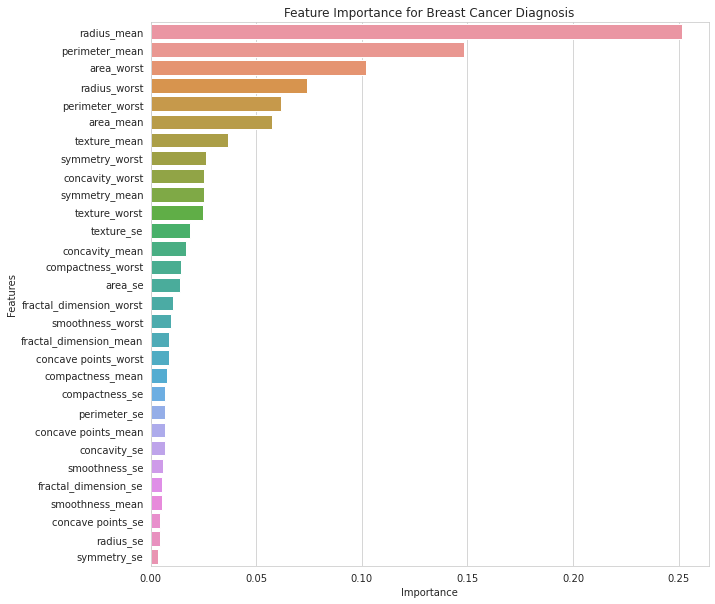

In [59]:
rfc_features = pd.DataFrame(zip(rfc_best.feature_importances_, df.columns[:-1]), columns = ['Importance', 'Features'])

# Sort in descending order
rfc_features = rfc_features.sort_values(['Importance'], ascending=False)

# Visualize RFC feature importances
fig = plt.figure(figsize=(10,10))
sns.barplot(x = 'Importance', y = 'Features', data = rfc_features, )
plt.title('Feature Importance for Breast Cancer Diagnosis')
sns.set_style("whitegrid")
plt.show()

In [61]:
from sklearn.feature_selection import RFECV

clf_lda = LinearDiscriminantAnalysis()
clf_rfc = RandomForestClassifier(**rfc_grid.best_params_, random_state=10)
clf_gbc = GradientBoostingClassifier(**gbc_grid.best_params_, random_state=10)

rfecv_lda = RFECV(clf_lda, step=1, cv=3, scoring='accuracy').fit(X_train_norm, y_train)
rfecv_rfc = RFECV(clf_rfc, step=1, cv=3, scoring='accuracy').fit(X_train_norm, y_train)
rfecv_gbc = RFECV(clf_gbc, step=1, cv=3, scoring='accuracy').fit(X_train_norm, y_train)

print('Optimal number of features for LDA: ', rfecv_lda.n_features_)
print('Best features for LDA: ', X_train.columns[rfecv_lda.support_])
print('\n')
print('Optimal number of features for RFC: ', rfecv_rfc.n_features_)
print('Best features for RFC: ', X_train.columns[rfecv_rfc.support_])
print('\n')
print('Optimal number of features for GBC: ', rfecv_gbc.n_features_)
print('Best features for GBC: ', X_train.columns[rfecv_gbc.support_])

Optimal number of features for LDA:  22
Best features for LDA:  Index(['radius_mean', 'perimeter_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'concave points_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'smoothness_worst', 'compactness_worst',
       'concavity_worst', 'concave points_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')


Optimal number of features for RFC:  9
Best features for RFC:  Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'radius_worst', 'perimeter_worst', 'area_worst', 'compactness_worst',
       'concavity_worst'],
      dtype='object')


Optimal number of features for GBC:  8
Best features for GBC:  Index(['radius_mean', 'area_mean', 'concavity_mean', 'radius_worst',
       'texture_worst', 'area_worst', 'compactn

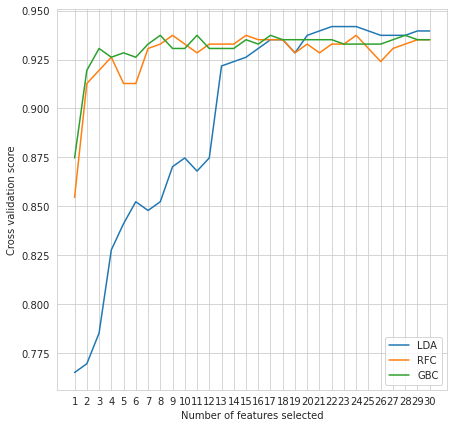

In [62]:
plt.figure(figsize=(7,7))
plt.xlabel('Number of features selected')
plt.xticks(np.arange(1, 31, 1))
plt.ylabel('Cross validation score')
plt.plot(range(1, len(rfecv_lda.grid_scores_) + 1), rfecv_lda.grid_scores_, label='LDA')
plt.plot(range(1, len(rfecv_rfc.grid_scores_) + 1), rfecv_rfc.grid_scores_, label='RFC')
plt.plot(range(1, len(rfecv_gbc.grid_scores_) + 1), rfecv_gbc.grid_scores_, label='GBC')
plt.legend(loc='lower right')
plt.show()

In [63]:
gbc_best_features = X_train.columns[rfecv_gbc.support_].tolist()
X_train_gbc_best = pd.DataFrame(X_train_norm, columns=X_train.columns)[gbc_best_features]
X_val_gbc_best = pd.DataFrame(X_val_norm, columns=X_val.columns)[gbc_best_features]

gbc_best_selected = GradientBoostingClassifier(**gbc_grid.best_params_, random_state=42)
gbc_best_selected.fit(X_train_gbc_best, y_train)
gbc_selected_predictions = gbc_best_selected.predict(X_val_gbc_best)
print('Model accuracy on validation data: {}'.format(accuracy_score(y_val, gbc_selected_predictions)))
print('GBC Classification Report')
print(classification_report(y_val, gbc_selected_predictions))

Model accuracy on validation data: 0.9821428571428571
GBC Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        79
           1       0.94      1.00      0.97        33

    accuracy                           0.98       112
   macro avg       0.97      0.99      0.98       112
weighted avg       0.98      0.98      0.98       112



In [64]:
confusion_matrix_gbc_best = pd.DataFrame(confusion_matrix(y_val, gbc_selected_predictions), index = ['Actual Negative','Actual Positive'], columns = ['Predicted Negative','Predicted Postive'] )
confusion_matrix_gbc_best

,Predicted Negative,Predicted Postive
Actual Negative,77,2
Actual Positive,0,33


In [65]:
rfc_best_features = X_train.columns[rfecv_rfc.support_].tolist()
X_train_rfc_best = pd.DataFrame(X_train_norm, columns=X_train.columns)[rfc_best_features]
X_val_rfc_best = pd.DataFrame(X_val_norm, columns=X_val.columns)[rfc_best_features]

rfc_best_selected = RandomForestClassifier(**rfc_grid.best_params_, random_state=42)
rfc_best_selected.fit(X_train_rfc_best, y_train)
rfc_selected_predictions = rfc_best_selected.predict(X_val_rfc_best)
print('Model accuracy on validation data: {}'.format(accuracy_score(y_val, rfc_selected_predictions)))
print('RFC Classification Report')
print(classification_report(y_val, rfc_selected_predictions))

Model accuracy on validation data: 0.9821428571428571
RFC Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        79
           1       0.94      1.00      0.97        33

    accuracy                           0.98       112
   macro avg       0.97      0.99      0.98       112
weighted avg       0.98      0.98      0.98       112



In [66]:
confusion_matrix_rfc_best = pd.DataFrame(confusion_matrix(y_val, rfc_selected_predictions), index = ['Actual Negative','Actual Positive'], columns = ['Predicted Negative','Predicted Postive'] )
confusion_matrix_rfc_best

,Predicted Negative,Predicted Postive
Actual Negative,77,2
Actual Positive,0,33


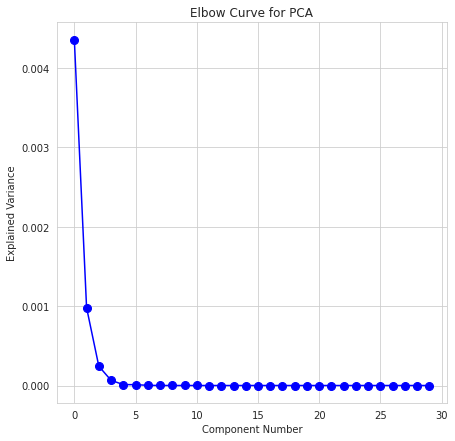

In [67]:
from sklearn.decomposition import PCA

# Instantiate PCA
pca_var = PCA()

# Fit PCA to training data
pca_var.fit(X_train_norm)

# Visualize explained variance with an increasing number of components
fig = plt.figure(figsize=(7,7))
plt.plot(pca_var.explained_variance_, 'bo-', markersize=8)
plt.title("Elbow Curve for PCA")
plt.ylabel('Explained Variance')
plt.xlabel('Component Number')
sns.set_style("whitegrid")
plt.show()

In [71]:
pca = PCA(n_components=4)
pca.fit(X_train_norm)
X_train_norm_pca = pca.transform(X_train_norm)
X_val_norm_pca = pca.transform(X_val_norm)

lda_pca = LinearDiscriminantAnalysis()
rfc_pca = RandomForestClassifier(**rfc_grid.best_params_, random_state=10)
gbc_pca = GradientBoostingClassifier(**gbc_grid.best_params_, random_state=10)

lda_pca.fit(X_train_norm_pca, y_train)
rfc_pca.fit(X_train_norm_pca, y_train)
gbc_pca.fit(X_train_norm_pca, y_train)

print('LDA accuracy on validation data: {}'.format(accuracy_score(y_val, lda_pca.predict(X_val_norm_pca))))
print('RFC accuracy on validation data: {}'.format(accuracy_score(y_val, rfc_pca.predict(X_val_norm_pca))))
print('GBC accuracy on validation data: {}'.format(accuracy_score(y_val, gbc_pca.predict(X_val_norm_pca))))

LDA accuracy on validation data: 0.9821428571428571
RFC accuracy on validation data: 0.9464285714285714
GBC accuracy on validation data: 0.9464285714285714


In [72]:
print('LDA_PCA Classification Report')
print(classification_report(y_val, lda_pca.predict(X_val_norm_pca)))

LDA_PCA Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        79
           1       0.97      0.97      0.97        33

    accuracy                           0.98       112
   macro avg       0.98      0.98      0.98       112
weighted avg       0.98      0.98      0.98       112



In [73]:
confusion_matrix_lda_pca = pd.DataFrame(confusion_matrix(y_val, lda_pca.predict(X_val_norm_pca)), index = ['Actual Negative','Actual Positive'], columns = ['Predicted Negative','Predicted Postive'] )
confusion_matrix_lda_pca

,Predicted Negative,Predicted Postive
Actual Negative,78,1
Actual Positive,1,32


In [0]:
from sklearn.model_selection import learning_curve, ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",  label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

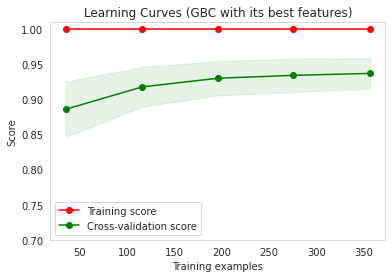

In [75]:
title = "Learning Curves (GBC with its best features)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(gbc_best_selected, title, X_train_gbc_best, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

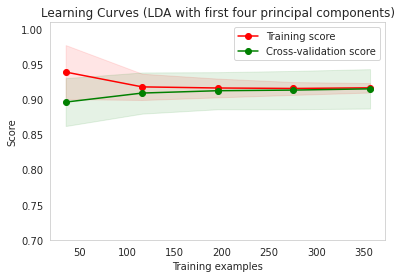

In [76]:
title = "Learning Curves (LDA with first four principal components)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(lda_pca, title, X_train_norm_pca, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

In [77]:
original_df = pd.read_csv('train-data.csv')
original_labels = original_df.tail(10)['diagnosis'].map({'M': 1, 'B': 0})

test_df = pd.read_csv('test-data.csv')
test_df.diagnosis = test_df.diagnosis.map({'M': 1, 'B': 0})
test_df.drop('id', axis=1, inplace=True)
X_test = test_df.iloc[:,:-1]
X_test_norm = norm.transform(X_test)

X_test_norm_pca = pca.transform(X_test_norm)
lda_labels = lda_pca.predict(X_test_norm_pca)

X_test_gbc_best = pd.DataFrame(X_test_norm, columns=X_test.columns)[gbc_best_features]
gbc_labels = gbc_best_selected.predict(X_test_gbc_best)

X_test_rfc_best = pd.DataFrame(X_test_norm, columns=X_test.columns)[rfc_best_features]
rfc_labels = rfc_best_selected.predict(X_test_rfc_best)

predictions = pd.DataFrame({'original':original_labels, 'lda_pca':lda_labels, 'gbc_best':gbc_labels, 'rfc_best':rfc_labels})

display(predictions)
print('Accuracy of LDA_PCA on test set is {}'.format(accuracy_score(original_labels, lda_labels)))
print('Accuracy of GBC_best on test set is {}'.format(accuracy_score(original_labels, gbc_labels)))
print('Accuracy of RFC_best on test set is {}'.format(accuracy_score(original_labels, rfc_labels)))

,original,lda_pca,gbc_best,rfc_best
559,0,0,0,0
560,0,0,0,0
561,0,0,0,0
562,1,0,1,1
563,1,1,1,1
564,1,1,1,1
565,1,1,1,1
566,1,1,1,1
567,1,1,1,1
568,0,0,0,0


Accuracy of LDA_PCA on test set is 0.9
Accuracy of GBC_best on test set is 1.0
Accuracy of RFC_best on test set is 1.0
